# Crop Prediction based on Soil Nutrients

# Introduction

$\textbf{Introduction}$: Industries throughout history rise and fall. The industries associated with horse-drawn technology fell and gave way to the rise of the automobile industry. However, one industry associated with the survival of the human race has stayed afloat for centuries -- agriculture. And nowhere does this fact hold more true than in India: one of the oldest human civilizations where over 60% of its population and roughly 20%  relies on agriculture for work and profit respectively (1). Despite agriculture playing such a key role in Indian society and careful crop diversity selection playing such a key role in long-term agriculture, it seems farmers seem to follow almost an abstract way of choosing which crops to pick for a specific year where "the role of aspirations and culture is central to shaping crop diversity" (2). Thus, it was natural for us and other researchers to attempt to create a more concrete process for these farmers (and potentially other farmers worldwide) to pick crops based on scientific properties of the soil in a given year. However, many of the past papers that attempted to design machine learning models that picked a crop to use for certain soil conditions simply proposed the concept of an ensemble model that used a basic majority vote approach providing no actual test results (6) or analyzed the accuracy of different models and simply chose one that had the highest accuracy (which many concluded was the Random Forest Model) (3, 4, 5). Though their accuracy rates that were between 95% to 98% seem theoretically good, for a farmer whose livelihood revolves around their crops, a 1 in 20 chance every year of the proper crop not being selected by a machine learning model they rely on does not seem too good. Thus, in this report, we set out to design and actually build and analyze a more comprehensive ensemble model to better predict the proper crop to grow based on soil conditions for not only Indian farmers that rely on crop selection for their livelihoods but also for other more recreational farmers.

$\textbf{Project Description}$: This project is a meant to serve as the final for Georgia Institute of Technology's CS 4641 Machine Learning Course.  The main goal of this project is to examine the performance of various supervised learning algorithms and, ultimately, bootstrap the algorithms together to demonstrate performance increases from bootstrapping algorithms together.

$\textbf{Algorithms}$: This project will use the following supervised learning algorithms:
1. Naive Bayes
2. Support Vector Machines (SVM)
3. K-nearest Neighbor
4. Decision Trees
5. Neural Networks

# Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import seaborn as sns
import matplotlib.pyplot as plt

##Loading the Data##

In [ ]:
data = pd.read_csv("./Crop_recommendation.csv")
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
label_mapping = {
    'apple': 0,
    'banana': 1,
    'blackgram': 2,
    'chickpea': 3,
    'coconut': 4,
    'coffee': 5,
    'cotton': 6,
    'grapes': 7,
    'jute': 8,
    'kidneybeans': 9,
    'lentil': 10,
    'maize': 11,
    'mango': 12,
    'mothbeans': 13,
    'mungbean': 14,
    'muskmelon': 15,
    'orange': 16,
    'papaya': 17,
    'pigeonpeas': 18,
    'pomegranate': 19,
    'rice': 20,
    'watermelon': 21
}

# Because there are 22 different categories we are going to use the 22 kelly 
# colors for the graphs [CITATION NEEDED]
graph_colors = ['#F2F3F4', '#222222', '#F3C300', '#875692', '#F38400', '#A1CAF1', 
                '#BE0032', '#C2B280', '#848482', '#008856', '#E68FAC', '#0067A5', 
                '#F99379', '#604E97', '#F6A600', '#B3446C', '#DCD300', '#882D17', 
                '#8DB600', '#654522', '#E25822', '#2B3D26']

labels = ['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton',
          'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango',
          'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas',
          'pomegranate', 'rice', 'watermelon']


In [ ]:
def encode_labels(data):
    new_data = data.replace({'label': label_mapping})
    return new_data

In [ ]:
# For testing it may be useful to know the data for each label of the data to test
# the accuracy of a model across each label
def get_data_by_label(data):
    data_by_label = []
    for i in range(22):
        data_by_label.append(data[data['label'] == i].loc[:, data.columns != 'label'])
    return data_by_label

def perform_accuracy_by_label(model, data_by_label):
    accuracies = []
    for i in range(22):
        y_preds = model.predict(data_by_label[i])
        total, num_correct = 0, 0
        for prediction in y_preds:
            if prediction == i:
                num_correct += 1
            total += 1
        accuracies.append(num_correct / total)
    return accuracies

In [ ]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return accuracy_score(y_pred, y_test)

In [ ]:
def full_model_evaluation(model, data, num_tests=10, test_size=0.1) -> float:
    """
    Evaluate a given model type a specific number of times with various training and testing data
    
    model : Type of model to train
    data : Data to train the model on
    num_tests : The number of various seeds to test the model on
    
    return : mean accuracy achieved by the model on the various tests
    """
    accuracy = np.zeros(num_tests)
    accuracy_by_labels = np.zeros(22)
    
    for i in range(num_tests):
        data_by_labels = get_data_by_label(data)
        x_train, x_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'label'], data['label'], test_size=test_size, shuffle=True)
        
        new_model = clone(model)
        new_model.fit(x_train, y_train)
        accuracy[i] = evaluate_model(new_model, x_test, y_test)

        if i == 0:
            accuracy_by_labels = perform_accuracy_by_label(new_model, data_by_labels)
        else:
            new_accuracy_by_labels = perform_accuracy_by_label(new_model, data_by_labels)
            for i in range(22):
                accuracy_by_labels[i] = (accuracy_by_labels[i] + new_accuracy_by_labels[i]) / 2
        
    print("maximum accuracy: {}".format(np.max(accuracy)))
    print("minimum accuracy: {}".format(np.min(accuracy)))
    print("average accuracy: {}".format(np.sum(accuracy) / num_tests))
    print()
    for i in range(22):
        print("Label [{}]: accuracy: {}".format(labels[i], accuracy_by_labels[i]))
    
    return np.sum(accuracy) / num_tests

In [ ]:
data = encode_labels(data)
x_train, x_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'label'], data['label'], test_size=0.1, shuffle=True)
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20


##Visualization##

### PCA Visualization ###

In [ ]:
def pca_plot_data(data):
    """Still in beta"""
    
    pca = sklearnPCA(n_components=2)

    new_data = data.replace({"label": label_mapping})
    
    x_data = new_data.loc[:, data.columns != 'label']
    y_data = new_data['label']
    
    transformed_data = pd.DataFrame(pca.fit_transform(x_data))
    transformed_data['label'] = y_data

    for i in range(22):
        plt.scatter(transformed_data[transformed_data['label'] == i][0], 
                    transformed_data[transformed_data['label'] == i][1], 
                    label=labels[i], 
                    c=graph_colors[i])
    
    plt.legend()
    plt.show()

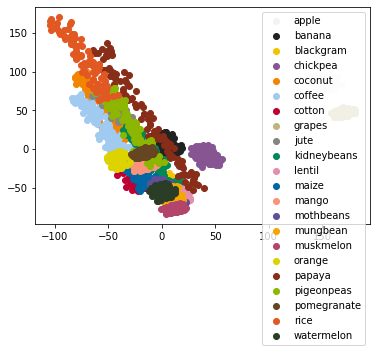

In [ ]:
pca_plot_data(data)

In [ ]:
def pca_plot_3d_data(data):
    pca = sklearnPCA(n_components=3)

    new_data = data.replace({"label": label_mapping})
    
    x_data = new_data.loc[:, data.columns != 'label']
    y_data = new_data['label']
    
    transformed_data = pd.DataFrame(pca.fit_transform(x_data))
    transformed_data['label'] = y_data

    ax = plt.axes(projection='3d')

    for i in range(22):
        ax.scatter3D(
            transformed_data[transformed_data['label'] == i][0],
            transformed_data[transformed_data['label'] == i][1],
            transformed_data[transformed_data['label'] == i][2],
            label = labels[i],
            c = graph_colors[i]
        )
    
    plt.legend()
    plt.show()

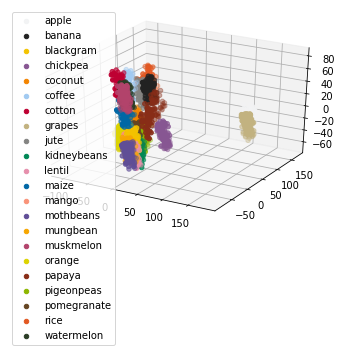

In [ ]:
pca_plot_3d_data(data)

### SVG Visualization ###

In [ ]:
def svg_plot_data(data):
    svd = SVD(n_components=2)

    new_data = data.replace({'label': label_mapping})

    x_data = new_data.loc[:, data.columns != 'label']
    y_data = new_data['label']

    svd.fit(x_data)
    transformed_data = pd.DataFrame(svd.transform(x_data))
    transformed_data['label'] = y_data

    for i in range(22):
        plt.scatter(transformed_data[transformed_data['label'] == i][0], 
                    transformed_data[transformed_data['label'] == i][1], 
                    label=labels[i], 
                    c=graph_colors[i])
    
    plt.legend()
    plt.show()


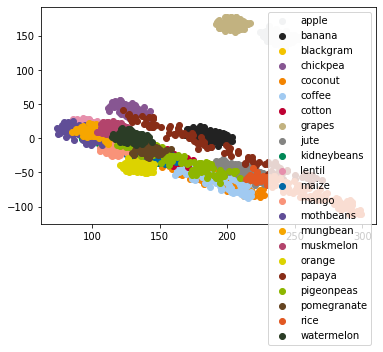

In [ ]:
svg_plot_data(data)

In [ ]:
def svg_plot_3d_data(data):
    svg = SVD(n_components=3)

    new_data = data.replace({"label": label_mapping})
    
    x_data = new_data.loc[:, data.columns != 'label']
    y_data = new_data['label']
    
    svg.fit(x_data)
    transformed_data = pd.DataFrame(svg.fit_transform(x_data))
    transformed_data['label'] = y_data

    ax = plt.axes(projection='3d')

    for i in range(22):
        ax.scatter3D(
            transformed_data[transformed_data['label'] == i][0],
            transformed_data[transformed_data['label'] == i][1],
            transformed_data[transformed_data['label'] == i][2],
            label = labels[i],
            c = graph_colors[i]
        )
    
    plt.legend()
    plt.show()

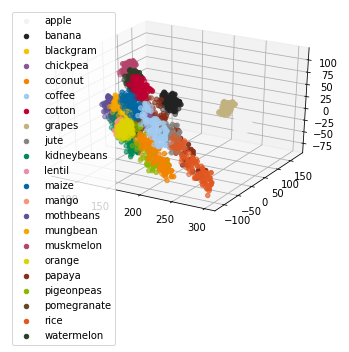

In [ ]:
svg_plot_3d_data(data)

##Features/Target Analysis##

Correlation Heat Map

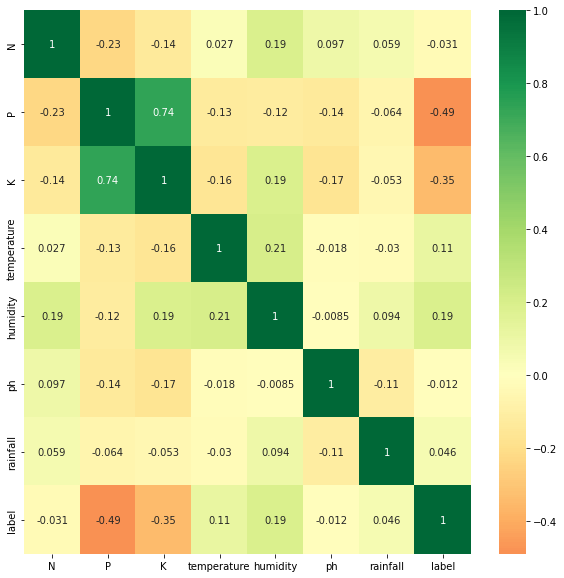

In [ ]:
plt.figure(figsize=(10,10))
g=sns.heatmap(data.corr(),annot=True,cmap="RdYlGn",center=0)

Variable Distributions and Pairwise Graphs of Each Feature

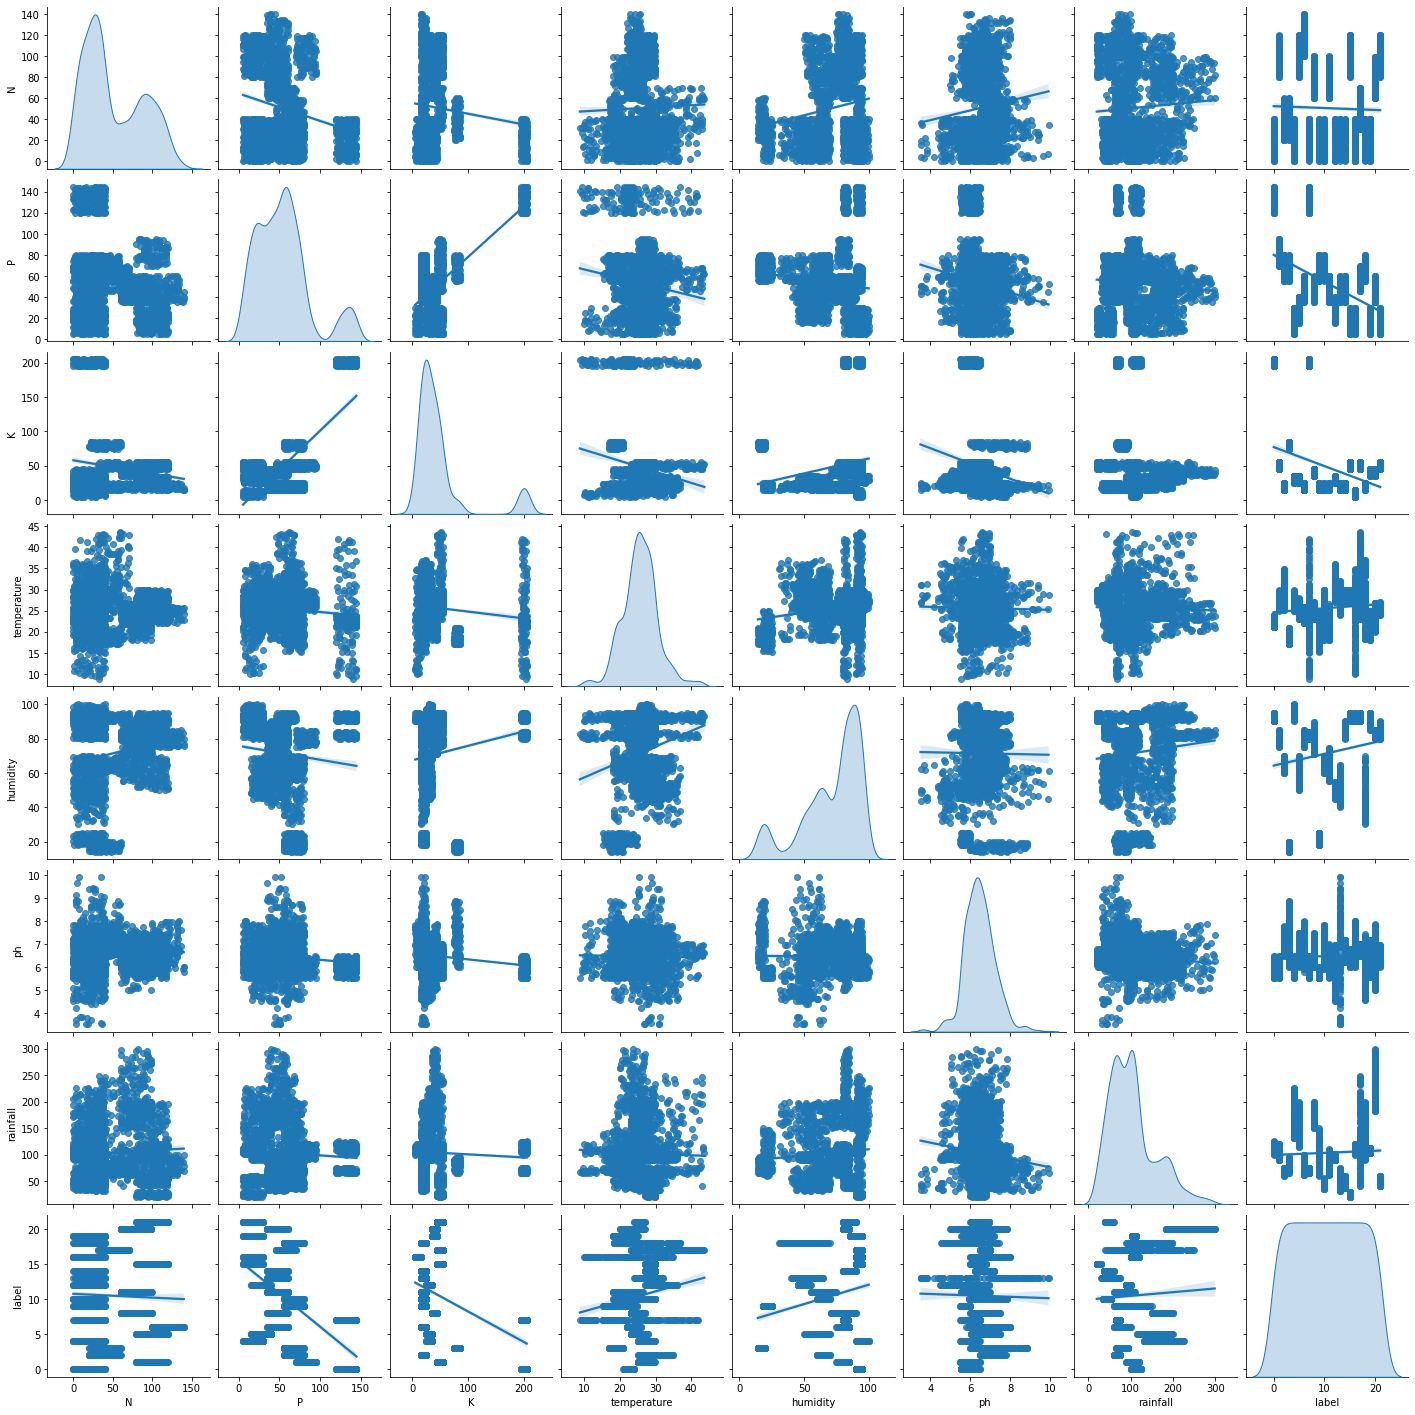

In [ ]:
sns.pairplot(data, kind="reg", diag_kind="kde")

Frequency of Labels

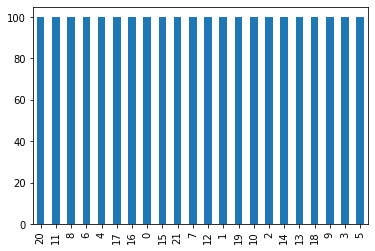

In [ ]:
data['label'].value_counts().plot(kind='bar');

# Naive Bayes

## Imports ##

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB

## Gaussian Naive Bayes ##

In [ ]:
gaussianNB = GaussianNB()
gaussian_accuracy = full_model_evaluation(gaussianNB, data)

maximum accuracy: 1.0
minimum accuracy: 0.9863636363636363
average accuracy: 0.9963636363636365

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 1.0
Label [cotton]: accuracy: 1.0
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.98
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 1.0
Label [maize]: accuracy: 0.99
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 1.0
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 1.0
Label [pigeonpeas]: accuracy: 1.0
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.92
Label [watermelon]: accuracy: 1.0


## Bernoulli Naive Bayes ##

In [ ]:
bernoulliNB = BernoulliNB()
bernoulli_accuracy = full_model_evaluation(bernoulliNB, data)

maximum accuracy: 0.02727272727272727
minimum accuracy: 0.013636363636363636
average accuracy: 0.022727272727272728

Label [apple]: accuracy: 0.0
Label [banana]: accuracy: 0.01953125
Label [blackgram]: accuracy: 0.0
Label [chickpea]: accuracy: 0.0
Label [coconut]: accuracy: 0.0064062500000000005
Label [coffee]: accuracy: 0.0
Label [cotton]: accuracy: 0.0390625
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.064453125
Label [kidneybeans]: accuracy: 0.245
Label [lentil]: accuracy: 0.023125
Label [maize]: accuracy: 0.5
Label [mango]: accuracy: 0.0
Label [mothbeans]: accuracy: 0.0
Label [mungbean]: accuracy: 0.0
Label [muskmelon]: accuracy: 0.125
Label [orange]: accuracy: 0.01046875
Label [papaya]: accuracy: 0.0
Label [pigeonpeas]: accuracy: 0.0
Label [pomegranate]: accuracy: 0.0
Label [rice]: accuracy: 0.0
Label [watermelon]: accuracy: 0.001953125


## Multinomial Naive Bayes ##

In [ ]:
multinomialNB = MultinomialNB()
multinomial_accuracy = full_model_evaluation(multinomialNB, data)

maximum accuracy: 0.9227272727272727
minimum accuracy: 0.8318181818181818
average accuracy: 0.8922727272727272

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 0.7593359375
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 0.9359375
Label [coffee]: accuracy: 1.0
Label [cotton]: accuracy: 0.95748046875
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.932265625
Label [kidneybeans]: accuracy: 0.955234375
Label [lentil]: accuracy: 0.76947265625
Label [maize]: accuracy: 0.8426757812499999
Label [mango]: accuracy: 0.90115234375
Label [mothbeans]: accuracy: 0.51671875
Label [mungbean]: accuracy: 0.981796875
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.429921875
Label [pigeonpeas]: accuracy: 0.84037109375
Label [pomegranate]: accuracy: 0.96998046875
Label [rice]: accuracy: 0.7822265625
Label [watermelon]: accuracy: 1.0


## Complement Naive Bayes ##

In [ ]:
complementNB = ComplementNB()
complement_accuracy = full_model_evaluation(complementNB, data)

maximum accuracy: 0.42727272727272725
minimum accuracy: 0.3181818181818182
average accuracy: 0.375

Label [apple]: accuracy: 0.0130078125
Label [banana]: accuracy: 0.00078125
Label [blackgram]: accuracy: 0.01595703125
Label [chickpea]: accuracy: 0.0
Label [coconut]: accuracy: 0.9683203125
Label [coffee]: accuracy: 0.6336132812499999
Label [cotton]: accuracy: 1.0
Label [grapes]: accuracy: 0.9974804687500001
Label [jute]: accuracy: 0.0
Label [kidneybeans]: accuracy: 0.25886718750000004
Label [lentil]: accuracy: 0.7525000000000001
Label [maize]: accuracy: 0.0
Label [mango]: accuracy: 0.0
Label [mothbeans]: accuracy: 0.001953125
Label [mungbean]: accuracy: 0.92884765625
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 0.042324218749999996
Label [papaya]: accuracy: 0.0
Label [pigeonpeas]: accuracy: 0.7014843749999999
Label [pomegranate]: accuracy: 0.0
Label [rice]: accuracy: 1.0
Label [watermelon]: accuracy: 0.0


# Support Vector Machines

In [ ]:
from sklearn import svm

In [ ]:
linear_svm = svm.SVC(kernel="linear", C=1, decision_function_shape="ovo")
linaer_svm_accuracy = full_model_evaluation(linear_svm, data)

maximum accuracy: 0.9954545454545455
minimum accuracy: 0.9727272727272728
average accuracy: 0.9868181818181819

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.99498046875
Label [cotton]: accuracy: 1.0
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.939140625
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 1.0
Label [maize]: accuracy: 0.99998046875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.9968359375
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 1.0
Label [pigeonpeas]: accuracy: 1.0
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.8897265624999999
Label [watermelon]: accuracy: 1.0


In [ ]:
rbf_svm = svm.SVC(kernel="rbf", gamma=1, C=1, decision_function_shape="ovo")
rbf_svm_accuracy = full_model_evaluation(rbf_svm, data)

maximum accuracy: 0.031818181818181815
minimum accuracy: 0.013636363636363636
average accuracy: 0.020909090909090912

Label [apple]: accuracy: 0.8929687500000001
Label [banana]: accuracy: 0.888671875
Label [blackgram]: accuracy: 0.95755859375
Label [chickpea]: accuracy: 0.8705078125000001
Label [coconut]: accuracy: 0.8890820312500001
Label [coffee]: accuracy: 0.90474609375
Label [cotton]: accuracy: 0.8951757812500001
Label [grapes]: accuracy: 0.9104882812499999
Label [jute]: accuracy: 0.8971093750000001
Label [kidneybeans]: accuracy: 0.9141015625
Label [lentil]: accuracy: 0.8828515625
Label [maize]: accuracy: 0.9182421875
Label [mango]: accuracy: 0.8994140625
Label [mothbeans]: accuracy: 0.907265625
Label [mungbean]: accuracy: 0.9052734375
Label [muskmelon]: accuracy: 0.9078710937500001
Label [orange]: accuracy: 0.8856445312500001
Label [papaya]: accuracy: 0.90595703125
Label [pigeonpeas]: accuracy: 0.8819335937499999
Label [pomegranate]: accuracy: 0.9324804687500001
Label [rice]: accu

In [ ]:
polynomial_svm = svm.SVC(kernel="poly", degree=3, C=1, decision_function_shape="ovo")
polynomial_svm_accuracy = full_model_evaluation(polynomial_svm, data)

maximum accuracy: 0.9863636363636363
minimum accuracy: 0.9681818181818181
average accuracy: 0.9795454545454547

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.9999609375
Label [cotton]: accuracy: 1.0
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.9102734375000001
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.98302734375
Label [maize]: accuracy: 0.984921875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.9800390625
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 1.0
Label [pigeonpeas]: accuracy: 0.95927734375
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.8737890625
Label [watermelon]: accuracy: 1.0


In [ ]:
sigmoid_svm = svm.SVC(kernel="sigmoid", C=1, decision_function_shape="ovo")
sigmoid_svm_accuracy = full_model_evaluation(sigmoid_svm, data)

maximum accuracy: 0.09545454545454546
minimum accuracy: 0.00909090909090909
average accuracy: 0.05636363636363636

Label [apple]: accuracy: 0.155
Label [banana]: accuracy: 0.10236328125
Label [blackgram]: accuracy: 0.005625
Label [chickpea]: accuracy: 0.005078125
Label [coconut]: accuracy: 0.02849609375
Label [coffee]: accuracy: 0.0674609375
Label [cotton]: accuracy: 0.12841796875
Label [grapes]: accuracy: 0.1675
Label [jute]: accuracy: 0.1104296875
Label [kidneybeans]: accuracy: 0.0031640625
Label [lentil]: accuracy: 7.8125e-05
Label [maize]: accuracy: 0.02244140625
Label [mango]: accuracy: 0.000234375
Label [mothbeans]: accuracy: 0.0
Label [mungbean]: accuracy: 0.0
Label [muskmelon]: accuracy: 0.50853515625
Label [orange]: accuracy: 0.18439453125
Label [papaya]: accuracy: 0.0
Label [pigeonpeas]: accuracy: 0.0
Label [pomegranate]: accuracy: 0.044843749999999995
Label [rice]: accuracy: 0.0125
Label [watermelon]: accuracy: 0.19816406250000002


# K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
one_neighbor = KNeighborsClassifier(n_neighbors=1)
one_neighbor_accuracy = full_model_evaluation(one_neighbor, data)

maximum accuracy: 0.990909090909091
minimum accuracy: 0.9636363636363636
average accuracy: 0.9804545454545455

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 0.9996875000000001
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.9998828125
Label [cotton]: accuracy: 0.99998046875
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.97935546875
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.9998242187499999
Label [maize]: accuracy: 0.999296875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.99873046875
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.999609375
Label [pigeonpeas]: accuracy: 0.99921875
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.9812695312499999
Label [watermelon]: accuracy: 1.0


In [ ]:
three_neighbor = KNeighborsClassifier(n_neighbors=3)
three_neighbor_accuracy = full_model_evaluation(three_neighbor, data)

maximum accuracy: 0.990909090909091
minimum accuracy: 0.9590909090909091
average accuracy: 0.9754545454545454

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.99
Label [cotton]: accuracy: 0.9938281250000001
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.932421875
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.99123046875
Label [maize]: accuracy: 0.97185546875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.97498046875
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.98998046875
Label [pigeonpeas]: accuracy: 0.98580078125
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.91501953125
Label [watermelon]: accuracy: 1.0


In [ ]:
five_neighbor = KNeighborsClassifier(n_neighbors=5)
five_neighbor_accuracy = full_model_evaluation(five_neighbor, data)

maximum accuracy: 0.9863636363636363
minimum accuracy: 0.9681818181818181
average accuracy: 0.9795454545454545

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.99
Label [cotton]: accuracy: 0.9999609375
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.9384375
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.98919921875
Label [maize]: accuracy: 0.9712695312499999
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.978984375
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.99
Label [pigeonpeas]: accuracy: 0.94939453125
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.9096484375
Label [watermelon]: accuracy: 1.0


In [ ]:
seven_neighbor = KNeighborsClassifier(n_neighbors=7)
seven_neighbor_accuracy = full_model_evaluation(seven_neighbor, data)

maximum accuracy: 0.990909090909091
minimum accuracy: 0.9636363636363636
average accuracy: 0.9804545454545452

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.99
Label [cotton]: accuracy: 0.99951171875
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.946953125
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.98966796875
Label [maize]: accuracy: 0.97123046875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.97599609375
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.9863671875
Label [pigeonpeas]: accuracy: 0.9408984375
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.87447265625
Label [watermelon]: accuracy: 1.0


# Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
decision_tree_1 = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree_1_accuracy = full_model_evaluation(decision_tree_1, data)

maximum accuracy: 0.2818181818181818
minimum accuracy: 0.1590909090909091
average accuracy: 0.21318181818181814

Label [apple]: accuracy: 0.96875
Label [banana]: accuracy: 0.0
Label [blackgram]: accuracy: 0.501953125
Label [chickpea]: accuracy: 0.9375
Label [coconut]: accuracy: 0.001953125
Label [coffee]: accuracy: 0.0
Label [cotton]: accuracy: 0.3125
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.0
Label [kidneybeans]: accuracy: 0.998046875
Label [lentil]: accuracy: 0.0
Label [maize]: accuracy: 0.00390625
Label [mango]: accuracy: 0.0
Label [mothbeans]: accuracy: 0.015625
Label [mungbean]: accuracy: 0.0078125
Label [muskmelon]: accuracy: 0.99609375
Label [orange]: accuracy: 0.0
Label [papaya]: accuracy: 0.0
Label [pigeonpeas]: accuracy: 0.0
Label [pomegranate]: accuracy: 0.125
Label [rice]: accuracy: 0.03125
Label [watermelon]: accuracy: 0.0


In [ ]:
decision_tree_2 = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree_2_accuracy = full_model_evaluation(decision_tree_2, data)

maximum accuracy: 0.43636363636363634
minimum accuracy: 0.3090909090909091
average accuracy: 0.37318181818181817

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 0.244140625
Label [blackgram]: accuracy: 0.0309375
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 0.653359375
Label [coffee]: accuracy: 0.220703125
Label [cotton]: accuracy: 0.265625
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.15625
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.130859375
Label [maize]: accuracy: 0.854140625
Label [mango]: accuracy: 0.125
Label [mothbeans]: accuracy: 0.064453125
Label [mungbean]: accuracy: 0.009765625
Label [muskmelon]: accuracy: 0.873046875
Label [orange]: accuracy: 0.314453125
Label [papaya]: accuracy: 0.2532421875
Label [pigeonpeas]: accuracy: 0.75
Label [pomegranate]: accuracy: 0.001953125
Label [rice]: accuracy: 0.00390625
Label [watermelon]: accuracy: 0.751953125


In [ ]:
decision_tree_3 = DecisionTreeClassifier(max_depth=7, random_state=42)
decision_tree_3_accuracy = full_model_evaluation(decision_tree_3, data)

maximum accuracy: 0.759090909090909
minimum accuracy: 0.5363636363636364
average accuracy: 0.6704545454545454

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 0.8671875
Label [blackgram]: accuracy: 0.02494140625
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 0.9356249999999999
Label [coffee]: accuracy: 0.998203125
Label [cotton]: accuracy: 0.7421875
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.3380859375
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.47867187499999997
Label [maize]: accuracy: 0.9225195312500001
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.78990234375
Label [mungbean]: accuracy: 0.568359375
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 0.375
Label [papaya]: accuracy: 0.9330859375
Label [pigeonpeas]: accuracy: 0.3671875
Label [pomegranate]: accuracy: 0.56875
Label [rice]: accuracy: 0.47390625
Label [watermelon]: accuracy: 0.6328125


# Neural Networks

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import copy

In [ ]:
def train_network(model, x_train, y_train, num_epochs, lr=0.1):
    x_tensor = torch.tensor(x_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values)

    loss_func = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.3)

    for epoch in range(num_epochs):
        y_predictions = model.forward(x_tensor)

        loss = loss_func(y_predictions, y_tensor)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


In [ ]:
def test_network(model, x_test, y_test):
    x_tensor = torch.tensor(x_test.values, dtype = torch.float32)
    y_tensor = torch.tensor(y_test.values)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        predictions = model(x_tensor).argmax(dim=1, keepdim=True)
        for i in range(len(y_test)):
            if predictions[i] == y_tensor[i]:
                correct += 1
            total += 1

    return correct / total

In [ ]:
def perform_accuracy_by_label_nn(model, data_by_label):
    accuracies = []
    model.eval()
    for i in range(22):
        total, num_correct = 0, 0
        with torch.no_grad():
            x_tensor = torch.tensor(data_by_label[i].values, dtype=torch.float32)
            predictions = model(x_tensor).argmax(dim=1, keepdim=True)
            for prediction in predictions:
                if prediction == i:
                    num_correct += 1
                total += 1
        accuracies.append(num_correct / total)
    return accuracies

In [ ]:
def full_model_evaluation_nn(model, data, num_tests=10, test_size=0.1, epochs=1000, lr=0.1):
    """
    Evaluate a given model type a specific number of times with various training and testing data
    
    model : Type of model to train
    data : Data to train the model on
    num_tests : The number of various seeds to test the model on
    
    return : mean accuracy achieved by the model on the various tests
    """
    accuracy = np.zeros(num_tests)
    accuracy_by_labels = np.zeros(22)
    
    for i in range(num_tests):
        data_by_labels = get_data_by_label(data)
        x_train, x_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'label'], data['label'], test_size=test_size, shuffle=True)
        
        new_model = copy.deepcopy(model)
        train_network(new_model, x_train, y_train, epochs, lr)
        accuracy[i] = test_network(new_model, x_test, y_test)

        if i == 0:
            accuracy_by_labels = perform_accuracy_by_label_nn(new_model, data_by_labels)
        else:
            new_accuracy_by_labels = perform_accuracy_by_label_nn(new_model, data_by_labels)
            for i in range(22):
                accuracy_by_labels[i] = (accuracy_by_labels[i] + new_accuracy_by_labels[i]) / 2
        
    print("maximum accuracy: {}".format(np.max(accuracy)))
    print("minimum accuracy: {}".format(np.min(accuracy)))
    print("average accuracy: {}".format(np.sum(accuracy) / num_tests))
    print()
    for i in range(22):
        print("Label [{}]: accuracy: {}".format(labels[i], accuracy_by_labels[i]))
    
    return np.sum(accuracy) / num_tests

## Dense Neural Network 1: 7x50x22 ##

In [ ]:
class one_hl_nn(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.layer2(input)
        input = self.sigmoid(input)

        return input

In [ ]:
nn_1 = one_hl_nn()
nn_1_accuracy = full_model_evaluation_nn(nn_1, data)

maximum accuracy: 0.08181818181818182
minimum accuracy: 0.013636363636363636
average accuracy: 0.046363636363636364

Label [apple]: accuracy: 0.33492187500000004
Label [banana]: accuracy: 0.671875
Label [blackgram]: accuracy: 0.0
Label [chickpea]: accuracy: 0.0
Label [coconut]: accuracy: 0.0
Label [coffee]: accuracy: 0.000859375
Label [cotton]: accuracy: 0.0
Label [grapes]: accuracy: 0.004140625
Label [jute]: accuracy: 0.0078125
Label [kidneybeans]: accuracy: 0.0003125
Label [lentil]: accuracy: 0.00703125
Label [maize]: accuracy: 0.0
Label [mango]: accuracy: 0.0
Label [mothbeans]: accuracy: 0.00140625
Label [mungbean]: accuracy: 0.0
Label [muskmelon]: accuracy: 0.0
Label [orange]: accuracy: 0.0
Label [papaya]: accuracy: 0.0
Label [pigeonpeas]: accuracy: 0.0
Label [pomegranate]: accuracy: 0.0
Label [rice]: accuracy: 0.0
Label [watermelon]: accuracy: 0.0


## Dense Neural Network 2: 7x100x22 ##

In [ ]:
class neural_network_2(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.layer2(input)
        input = self.sigmoid(input)

        return input

In [ ]:
nn_2 = neural_network_2()
nn_2_accuracy = full_model_evaluation_nn(nn_2, data, lr=0.5)

maximum accuracy: 0.09090909090909091
minimum accuracy: 0.022727272727272728
average accuracy: 0.05

Label [apple]: accuracy: 0.0
Label [banana]: accuracy: 0.0
Label [blackgram]: accuracy: 0.0
Label [chickpea]: accuracy: 0.0
Label [coconut]: accuracy: 0.0
Label [coffee]: accuracy: 1.0
Label [cotton]: accuracy: 0.0
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.0
Label [kidneybeans]: accuracy: 0.0
Label [lentil]: accuracy: 0.13468750000000002
Label [maize]: accuracy: 0.0
Label [mango]: accuracy: 0.0
Label [mothbeans]: accuracy: 0.0
Label [mungbean]: accuracy: 0.0
Label [muskmelon]: accuracy: 0.0
Label [orange]: accuracy: 0.0
Label [papaya]: accuracy: 0.0
Label [pigeonpeas]: accuracy: 0.0
Label [pomegranate]: accuracy: 0.0
Label [rice]: accuracy: 0.0
Label [watermelon]: accuracy: 0.0


## Dense Neural Network 3: 7x50x50x22 ##

In [ ]:
class neural_network_3(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.layer3(input)
        input = self.sigmoid(input)

        return input

In [ ]:
nn_3 = neural_network_3()
nn_3_accuracy = full_model_evaluation_nn(nn_3, data, lr=0.5)

maximum accuracy: 0.7272727272727273
minimum accuracy: 0.02727272727272727
average accuracy: 0.23681818181818176

Label [apple]: accuracy: 0.0
Label [banana]: accuracy: 0.28125
Label [blackgram]: accuracy: 0.3176953125
Label [chickpea]: accuracy: 0.03125
Label [coconut]: accuracy: 0.936484375
Label [coffee]: accuracy: 0.25
Label [cotton]: accuracy: 0.0987109375
Label [grapes]: accuracy: 0.287109375
Label [jute]: accuracy: 0.005
Label [kidneybeans]: accuracy: 0.2848046875
Label [lentil]: accuracy: 0.2810546875
Label [maize]: accuracy: 0.28515625
Label [mango]: accuracy: 0.28515625
Label [mothbeans]: accuracy: 0.24910156249999998
Label [mungbean]: accuracy: 0.28453125
Label [muskmelon]: accuracy: 0.0
Label [orange]: accuracy: 0.06015625
Label [papaya]: accuracy: 0.25
Label [pigeonpeas]: accuracy: 0.28265625
Label [pomegranate]: accuracy: 0.28515625
Label [rice]: accuracy: 0.00390625
Label [watermelon]: accuracy: 0.25390625


## Dense Neural Network 4: 7x100x100x100x22 ##

In [ ]:
class neural_network_4(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.layer4 = nn.Linear(100, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, input):
        input = self.layer1(input)
        input = self.tanh(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.layer3(input)
        input = self.relu(input)
        input = self.layer4(input)
        input = self.sigmoid(input)

        return input

In [ ]:
nn_4 = neural_network_4()
nn_4_accuracy = full_model_evaluation_nn(nn_4, data, lr=0.5)

maximum accuracy: 0.6045454545454545
minimum accuracy: 0.4681818181818182
average accuracy: 0.5254545454545454

Label [apple]: accuracy: 0.0
Label [banana]: accuracy: 0.01013671875
Label [blackgram]: accuracy: 0.6343554687499999
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 0.99921875
Label [coffee]: accuracy: 0.02875
Label [cotton]: accuracy: 0.0
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.9903124999999999
Label [kidneybeans]: accuracy: 0.70080078125
Label [lentil]: accuracy: 0.291875
Label [maize]: accuracy: 0.9932421874999999
Label [mango]: accuracy: 0.038554687500000004
Label [mothbeans]: accuracy: 0.9054101562500001
Label [mungbean]: accuracy: 0.996875
Label [muskmelon]: accuracy: 0.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.9934765624999999
Label [pigeonpeas]: accuracy: 0.9690234375
Label [pomegranate]: accuracy: 0.9924609375
Label [rice]: accuracy: 0.0
Label [watermelon]: accuracy: 1.953125e-05


## Dense Neural Network 5: 7x100x100x22

In [ ]:
class neural_network_5(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.layer3(input)
        input = self.sigmoid(input)

        return input

In [ ]:
nn_5 = neural_network_5()
nn_5_accuracy = full_model_evaluation_nn(nn_5, data, lr=0.5)

maximum accuracy: 0.7772727272727272
minimum accuracy: 0.05909090909090909
average accuracy: 0.5913636363636364

Label [apple]: accuracy: 0.827109375
Label [banana]: accuracy: 0.448125
Label [blackgram]: accuracy: 0.4021484375
Label [chickpea]: accuracy: 0.26623046875
Label [coconut]: accuracy: 0.481875
Label [coffee]: accuracy: 0.1328125
Label [cotton]: accuracy: 0.10265625
Label [grapes]: accuracy: 0.0004296875
Label [jute]: accuracy: 0.039492187500000005
Label [kidneybeans]: accuracy: 0.4349609375
Label [lentil]: accuracy: 0.43287109375
Label [maize]: accuracy: 0.4375
Label [mango]: accuracy: 0.4375
Label [mothbeans]: accuracy: 0.3740234375
Label [mungbean]: accuracy: 0.4375
Label [muskmelon]: accuracy: 0.03859375
Label [orange]: accuracy: 0.4375
Label [papaya]: accuracy: 0.4357421875
Label [pigeonpeas]: accuracy: 0.4375
Label [pomegranate]: accuracy: 0.4375
Label [rice]: accuracy: 0.0033203125
Label [watermelon]: accuracy: 0.4296875


## Dropout Neural Network 1 ##

In [ ]:
class dropout_network_1(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.05)

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer3(input)
        input = self.sigmoid(input)

        return input

In [ ]:
dropout_nn_1 = dropout_network_1()
dropout_nn_1_accuracy = full_model_evaluation_nn(dropout_nn_1, data, lr=0.5)

maximum accuracy: 0.8363636363636363
minimum accuracy: 0.7090909090909091
average accuracy: 0.7559090909090909

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 0.0003515625
Label [blackgram]: accuracy: 0.8641796875000001
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 0.998984375
Label [coffee]: accuracy: 0.18953124999999998
Label [cotton]: accuracy: 0.31056640625
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.11140625000000001
Label [kidneybeans]: accuracy: 0.9700390625
Label [lentil]: accuracy: 0.97169921875
Label [maize]: accuracy: 1.0
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.91966796875
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 0.35876953125
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.97357421875
Label [pigeonpeas]: accuracy: 0.98130859375
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.974375
Label [watermelon]: accuracy: 0.9983593749999999


## Smaller Dropout Network 2 ##

In [ ]:
class dropout_network_2(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.05)

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer3(input)
        input = self.sigmoid(input)

        return input

In [ ]:
dropout_nn_2 = dropout_network_2()
dropout_nn_2_accuracy = full_model_evaluation_nn(dropout_nn_2, data, lr=0.5)

maximum accuracy: 0.8909090909090909
minimum accuracy: 0.7727272727272727
average accuracy: 0.8504545454545456

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 0.88349609375
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 0.996796875
Label [cotton]: accuracy: 0.36802734375
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.94333984375
Label [kidneybeans]: accuracy: 0.9629296875
Label [lentil]: accuracy: 0.98720703125
Label [maize]: accuracy: 1.0
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.8590625000000001
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 0.31140625
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.98990234375
Label [pigeonpeas]: accuracy: 0.98998046875
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.70921875
Label [watermelon]: accuracy: 1.0


## Large Dropout Neural Network ##

In [ ]:
class large_dropout_network(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.layer4 = nn.Linear(100, 100)
        self.layer5 = nn.Linear(100, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.05)

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer3(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer4(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer5(input)
        input = self.sigmoid(input)

        return input

In [ ]:
large_dropout_net = large_dropout_network()
large_dropout_net_accuracy = full_model_evaluation_nn(large_dropout_net, data, lr=0.5)

maximum accuracy: 0.9045454545454545
minimum accuracy: 0.8045454545454546
average accuracy: 0.864090909090909

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 0.8943359375
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 1.0
Label [cotton]: accuracy: 0.27373046875
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.9803515625
Label [kidneybeans]: accuracy: 0.9898828125
Label [lentil]: accuracy: 0.97708984375
Label [maize]: accuracy: 1.0
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.9164062500000001
Label [mungbean]: accuracy: 0.99875
Label [muskmelon]: accuracy: 0.89017578125
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.96921875
Label [pigeonpeas]: accuracy: 0.996953125
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.215859375
Label [watermelon]: accuracy: 1.0


## High Dropout Rate Large Model ##

In [ ]:
class large_dropout_network_2(nn.Module):
    def __init__(self, input_dim = 7, output_dim = 22):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.layer4 = nn.Linear(100, 100)
        self.layer5 = nn.Linear(100, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input):
        input = self.layer1(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer2(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer3(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer4(input)
        input = self.relu(input)
        input = self.dropout(input)
        input = self.layer5(input)
        input = self.sigmoid(input)

        return input

In [ ]:
high_dropout_model = large_dropout_network_2()
high_dropout_model_accuracy = full_model_evaluation_nn(high_dropout_model, data, lr=0.5)

maximum accuracy: 0.8454545454545455
minimum accuracy: 0.7454545454545455
average accuracy: 0.7981818181818181

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 0.7447851562500001
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 0.99984375
Label [coffee]: accuracy: 0.9874804687500001
Label [cotton]: accuracy: 0.369375
Label [grapes]: accuracy: 0.0
Label [jute]: accuracy: 0.961875
Label [kidneybeans]: accuracy: 0.970703125
Label [lentil]: accuracy: 0.19396484375
Label [maize]: accuracy: 0.999296875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 0.93912109375
Label [mungbean]: accuracy: 0.99732421875
Label [muskmelon]: accuracy: 0.997421875
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.97091796875
Label [pigeonpeas]: accuracy: 0.9781640625
Label [pomegranate]: accuracy: 1.0
Label [rice]: accuracy: 0.0
Label [watermelon]: accuracy: 0.29771484375


# Stacked Classifiers #

## Imports ##

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Stacking Top 3 Performing Classifiers #

In [ ]:
def full_stacking_3_evaluation(model1, model2, model3, data, num_tests=10, test_size=0.1) -> float:
    accuracy = np.zeros(num_tests)
    accuracy_by_labels = np.zeros(22)

    for i in range(num_tests):
        data_by_labels = get_data_by_label(data)
        x_train, x_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'label'], data['label'], test_size=test_size, shuffle=True)

        new_model_1 = clone(model1)
        new_model_2 = clone(model2)
        new_model_3 = clone(model3)

        estimators = [('1', new_model_1), ('2', new_model_2), ('3', new_model_3)]
        stacking_classifier = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(max_iter=10000)
        )

        stacking_classifier.fit(x_train, y_train)
        accuracy[i] = evaluate_model(stacking_classifier, x_test, y_test)

        if i == 0:
            accuracy_by_labels = perform_accuracy_by_label(stacking_classifier, data_by_labels)
        else:
            new_accuracy_by_labels = perform_accuracy_by_label(stacking_classifier, data_by_labels)
            for i in range(22):
                accuracy_by_labels[i] = (accuracy_by_labels[i] + new_accuracy_by_labels[i]) / 2

    print("maximum accuracy: {}".format(np.max(accuracy)))
    print("minimum accuracy: {}".format(np.min(accuracy)))
    print("average accuracy: {}".format(np.sum(accuracy) / num_tests))
    print()
    for i in range(22):
        print("Label [{}]: accuracy: {}".format(labels[i], accuracy_by_labels[i]))
    
    return np.sum(accuracy) / num_tests

In [ ]:
stacking_accuracy = full_stacking_3_evaluation(
    GaussianNB(),
    svm.SVC(kernel="linear", C=1, decision_function_shape="ovo"),
    KNeighborsClassifier(n_neighbors=7),
    data
)

maximum accuracy: 0.9954545454545455
minimum accuracy: 0.9681818181818181
average accuracy: 0.9886363636363636

Label [apple]: accuracy: 1.0
Label [banana]: accuracy: 1.0
Label [blackgram]: accuracy: 1.0
Label [chickpea]: accuracy: 1.0
Label [coconut]: accuracy: 1.0
Label [coffee]: accuracy: 1.0
Label [cotton]: accuracy: 1.0
Label [grapes]: accuracy: 1.0
Label [jute]: accuracy: 0.93599609375
Label [kidneybeans]: accuracy: 1.0
Label [lentil]: accuracy: 0.9975
Label [maize]: accuracy: 0.99013671875
Label [mango]: accuracy: 1.0
Label [mothbeans]: accuracy: 1.0
Label [mungbean]: accuracy: 1.0
Label [muskmelon]: accuracy: 1.0
Label [orange]: accuracy: 1.0
Label [papaya]: accuracy: 0.99951171875
Label [pigeonpeas]: accuracy: 0.98443359375
Label [pomegranate]: accuracy: 0.9946484375
Label [rice]: accuracy: 0.93294921875
Label [watermelon]: accuracy: 1.0


# Bibliography

1. [https://www.ripublication.com/ijafst_spl/ijafstv4n4spl_11.pdf](http://)
2. [https://www.sciencedirect.com/science/article/pii/S266604902100044X](http://)
3. [https://ieeexplore.ieee.org/document/9418351](http://)
4. [https://www.irjet.net/archives/V9/i4/IRJET-V9I4214.pdf](http://)
5. [https://www.riteshajoodha.co.za/sitepad-data/uploads/2021/10/TakalaniIMITEC.pdf](http://)
6. [https://www.researchgate.net/publication/331426761_Crop_Recommendation_System_to_ Maximize_Crop_Yield_in_Ramtek_region_using_Machine_Learning](http://)
